# 1. Importing librairies and data

In [1]:
# Import librairies

import numpy as np
import pandas as pd
import seaborn as sns
import regex as re


import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8) #Adjusts the confguration of the plots we will create


#Importing and reviewing the data

movies_raw_data = pd.read_csv("movies.csv")
movies_raw_data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8.4,927000.0,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000.0,46998772.0,Warner Bros.,146.0
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5.8,65000.0,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000.0,58853106.0,Columbia Pictures,104.0
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8.7,1200000.0,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000.0,538375067.0,Lucasfilm,124.0
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7.7,221000.0,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000.0,83453539.0,Paramount Pictures,88.0
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7.3,108000.0,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000.0,39846344.0,Orion Pictures,98.0


In [2]:
#Finding potential missing data
#Using a loop to find out the percentage of missing data in each column
for col in movies_raw_data.columns:
    pct_missing = np.mean(movies_raw_data[col].isnull())
    print("{} - {}%".format(col, round(pct_missing,2)))

name - 0.0%
rating - 0.01%
genre - 0.0%
year - 0.0%
released - 0.0%
score - 0.0%
votes - 0.0%
director - 0.0%
writer - 0.0%
star - 0.0%
country - 0.0%
budget - 0.28%
gross - 0.02%
company - 0.0%
runtime - 0.0%


In [3]:
#Looking at the columns types
movies_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      7668 non-null   object 
 1   rating    7591 non-null   object 
 2   genre     7668 non-null   object 
 3   year      7668 non-null   int64  
 4   released  7666 non-null   object 
 5   score     7665 non-null   float64
 6   votes     7665 non-null   float64
 7   director  7668 non-null   object 
 8   writer    7665 non-null   object 
 9   star      7667 non-null   object 
 10  country   7665 non-null   object 
 11  budget    5497 non-null   float64
 12  gross     7479 non-null   float64
 13  company   7651 non-null   object 
 14  runtime   7664 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 898.7+ KB


# 2. Data cleaning

In [4]:
#Transforming float columns into integer (to remove .0 at the end of the numbers)

#First : remove nan values from the columns 
movies_raw_data = movies_raw_data.dropna()
movies_raw_data
# Then : Transform the columns types
movies_raw_data["score"] = movies_raw_data["score"].astype("int64")
movies_raw_data["votes"] = movies_raw_data["votes"].astype("int64")
movies_raw_data["budget"] = movies_raw_data["budget"].astype("int64")
movies_raw_data["gross"] = movies_raw_data["gross"].astype("int64")
movies_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5421 entries, 0 to 7652
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      5421 non-null   object 
 1   rating    5421 non-null   object 
 2   genre     5421 non-null   object 
 3   year      5421 non-null   int64  
 4   released  5421 non-null   object 
 5   score     5421 non-null   int64  
 6   votes     5421 non-null   int64  
 7   director  5421 non-null   object 
 8   writer    5421 non-null   object 
 9   star      5421 non-null   object 
 10  country   5421 non-null   object 
 11  budget    5421 non-null   int64  
 12  gross     5421 non-null   int64  
 13  company   5421 non-null   object 
 14  runtime   5421 non-null   float64
dtypes: float64(1), int64(5), object(9)
memory usage: 677.6+ KB


When looking at the data source explanation on Kaggle, we can see that both columns "year" and "released date" are supposed to indicate the year the film was realeased, however, while looking at the data, both columns don't always match.
Here is an example

In [5]:
#Death and the Maiden Molly's Game
movies_raw_data[movies_raw_data["name"] == "Death and the Maiden"]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime
2531,Death and the Maiden,R,Drama,1994,"January 27, 1995 (United States)",7,23000,Roman Polanski,Ariel Dorfman,Sigourney Weaver,United Kingdom,12000000,3103716,Fine Line Features,103.0


To keep a more precise date, I will use the "released" column year to create a "new_release" column.
I will delete the countries indicated in the old released columns since movies are released around the same date around the world

In [6]:
#Using regex to delete countries in the released column
new_release = []

for i,v in movies_raw_data["released"].items():
    v = re.sub(r'\([^)]*\)', '', v)
    v = v.strip()
    new_release.append(v)
movies_raw_data["new_released_date"] = new_release


#Taking the year from "new_released_date" and placing it in the "correct_year" column
#Transforming the new column into "int64"
correct_year = []
for i,v in movies_raw_data["new_released_date"].items():
    correct_year.append(v[-4:])
movies_raw_data["correct_year"] = correct_year
movies_raw_data["correct_year"] = movies_raw_data["correct_year"].astype("int64")

In [7]:
#708 rows didn't match 
movies_raw_data[movies_raw_data["correct_year"] != movies_raw_data["year"]]

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,new_released_date,correct_year
8,Superman II,PG,Action,1980,"June 19, 1981 (United States)",6,101000,Richard Lester,Jerry Siegel,Gene Hackman,United States,54000000,108185706,Dovemead Films,127.0,"June 19, 1981",1981
11,The Gods Must Be Crazy,PG,Adventure,1980,"October 26, 1984 (United States)",7,54000,Jamie Uys,Jamie Uys,N!xau,South Africa,5000000,30031783,C.A.T. Films,109.0,"October 26, 1984",1984
21,Heaven's Gate,R,Adventure,1980,"April 24, 1981 (United States)",6,14000,Michael Cimino,Michael Cimino,Kris Kristofferson,United States,44000000,3484523,Partisan Productions,219.0,"April 24, 1981",1981
33,Cattle Annie and Little Britches,PG,Drama,1980,"April 24, 1981 (United States)",6,604,Lamont Johnson,David Eyre,Scott Glenn,United States,5100000,534816,Cattle Annie Productions,97.0,"April 24, 1981",1981
96,The Evil Dead,NC-17,Horror,1981,"April 15, 1983 (United States)",7,192000,Sam Raimi,Sam Raimi,Bruce Campbell,United States,350000,2956630,Renaissance Pictures,85.0,"April 15, 1983",1983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7427,Stan & Ollie,PG,Biography,2018,"January 11, 2019 (United Kingdom)",7,34000,Jon S. Baird,Jeff Pope,Steve Coogan,United Kingdom,10000000,24420923,Entertainment One,98.0,"January 11, 2019",2019
7432,Dragon Ball Super: Broly,PG,Animation,2018,"January 16, 2019 (United States)",7,24000,Tatsuya Nagamine,Akira Toriyama,Masako Nozawa,Japan,8500000,115757940,Toei Company,100.0,"January 16, 2019",2019
7462,1917,R,Drama,2019,"January 10, 2020 (United States)",8,473000,Sam Mendes,Sam Mendes,Dean-Charles Chapman,United States,95000000,384623579,Dreamworks Pictures,119.0,"January 10, 2020",2020
7525,Weathering with You,PG-13,Animation,2019,"January 17, 2020 (United States)",7,28000,Makoto Shinkai,Makoto Shinkai,Kotaro Daigo,Japan,11100000,193457467,"""Weathering With You"" Film Partners",112.0,"January 17, 2020",2020


In [8]:
#Ordering the movies by gross revenues
movies_raw_data.sort_values(by = ["gross"], ascending = False, inplace = False )
#Finding and deleting any duplicates
movies_raw_data.drop_duplicates()
#No duplicates found, we can see that this dataframe has the number of rows than the previous one

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,new_released_date,correct_year
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146.0,"June 13, 1980",1980
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104.0,"July 2, 1980",1980
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124.0,"June 20, 1980",1980
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88.0,"July 2, 1980",1980
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98.0,"July 25, 1980",1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7648,Bad Boys for Life,R,Action,2020,"January 17, 2020 (United States)",6,140000,Adil El Arbi,Peter Craig,Will Smith,United States,90000000,426505244,Columbia Pictures,124.0,"January 17, 2020",2020
7649,Sonic the Hedgehog,PG,Action,2020,"February 14, 2020 (United States)",6,102000,Jeff Fowler,Pat Casey,Ben Schwartz,United States,85000000,319715683,Paramount Pictures,99.0,"February 14, 2020",2020
7650,Dolittle,PG,Adventure,2020,"January 17, 2020 (United States)",5,53000,Stephen Gaghan,Stephen Gaghan,Robert Downey Jr.,United States,175000000,245487753,Universal Pictures,101.0,"January 17, 2020",2020
7651,The Call of the Wild,PG,Adventure,2020,"February 21, 2020 (United States)",6,42000,Chris Sanders,Michael Green,Harrison Ford,Canada,135000000,111105497,20th Century Studios,100.0,"February 21, 2020",2020


# 3. Correlation analysis

Correlation hypothesis:
1 : A movie's budget and its gross revenue are highly correlated (the more money is invested in a movie, the more earning it generates)
2 : The company realeasing the film and the gross revenues also have a high correlation (film released by well know companies such as disney generate more earnings).

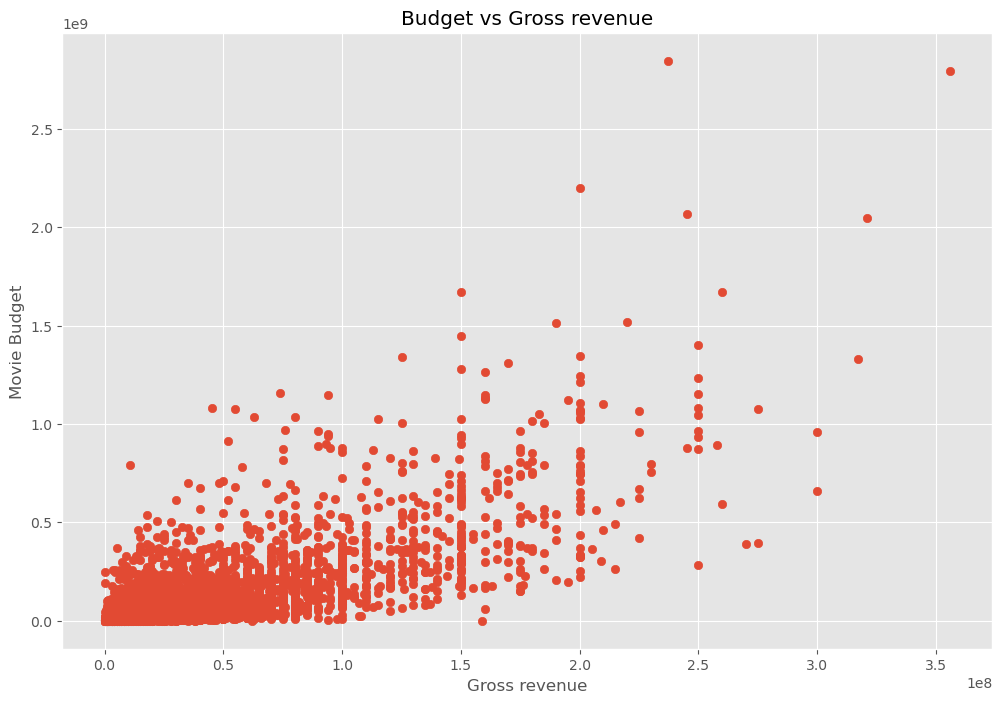

In [9]:
#Scatter plot budget vs gross revenue

plt.scatter( x = movies_raw_data["budget"], y = movies_raw_data["gross"])
plt.title("Budget vs Gross revenue")

plt.xlabel("Gross revenue")
plt.ylabel("Movie Budget")

plt.show()

<AxesSubplot:xlabel='budget', ylabel='gross'>

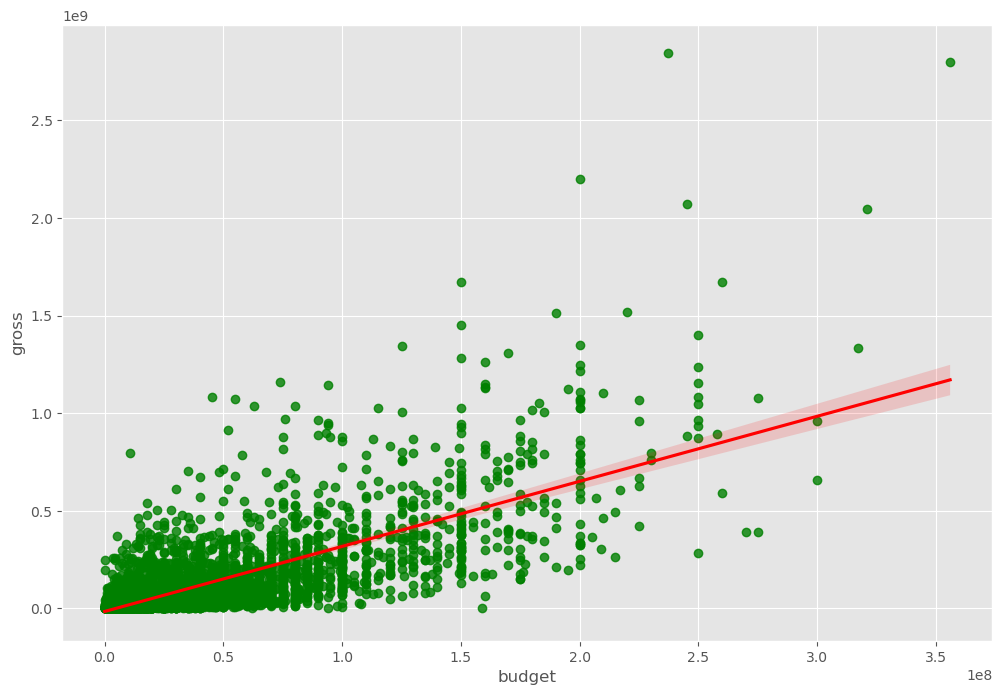

In [10]:
#Using seaborn to display a regressionplot
sns.regplot(x = "budget", y = "gross", data = movies_raw_data, scatter_kws = {"color" : "green"}, line_kws={"color" : "red"})

## 3.1 Budget and gross revenue correlation

In [11]:
#Pearson correlation
movies_raw_data.corr(method = "pearson")

,year,score,votes,budget,gross,runtime,correct_year
year,1.000000,0.057013,0.206021,0.327722,0.274321,0.075077,0.998726
score,0.057013,1.000000,0.455808,0.066443,0.211973,0.394589,0.062234
votes,0.206021,0.455808,1.000000,0.439675,0.614751,0.352303,0.203098
budget,0.327722,0.066443,0.439675,1.000000,0.740247,0.318695,0.320312
gross,0.274321,0.211973,0.614751,0.740247,1.000000,0.275796,0.268721
runtime,0.075077,0.394589,0.352303,0.318695,0.275796,1.000000,0.075294
correct_year,0.998726,0.062234,0.203098,0.320312,0.268721,0.075294,1.000000


High correlation between budget and gross revenue

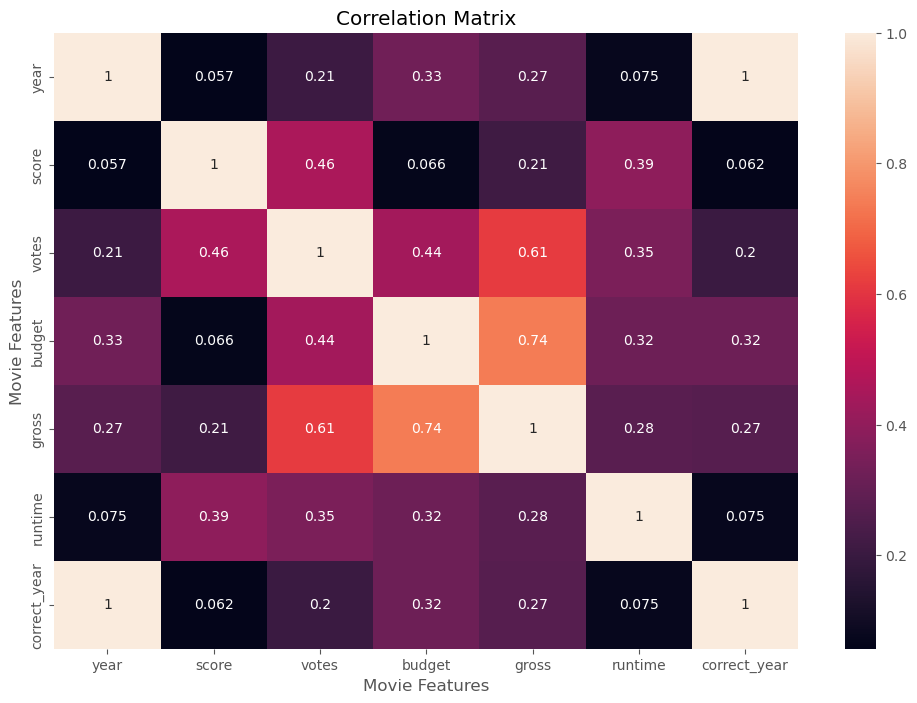

In [12]:
#Using the correlation matrix to display a heatmap
correlation_matrix = movies_raw_data.corr(method = "pearson")

sns.heatmap(correlation_matrix, annot = True)
plt.title("Correlation Matrix")

plt.xlabel("Movie Features")
plt.ylabel("Movie Features")

plt.show()

## 3.2 Company and gross revenue correlation

The correlation matrix only includes columns with numerical values, but I also want want to compare the gross revenues with the company who made the movies and see if I can find a correlation.

In [13]:
#Look at company
movies_raw_data.head()

,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,new_released_date,correct_year
0,The Shining,R,Drama,1980,"June 13, 1980 (United States)",8,927000,Stanley Kubrick,Stephen King,Jack Nicholson,United Kingdom,19000000,46998772,Warner Bros.,146.0,"June 13, 1980",1980
1,The Blue Lagoon,R,Adventure,1980,"July 2, 1980 (United States)",5,65000,Randal Kleiser,Henry De Vere Stacpoole,Brooke Shields,United States,4500000,58853106,Columbia Pictures,104.0,"July 2, 1980",1980
2,Star Wars: Episode V - The Empire Strikes Back,PG,Action,1980,"June 20, 1980 (United States)",8,1200000,Irvin Kershner,Leigh Brackett,Mark Hamill,United States,18000000,538375067,Lucasfilm,124.0,"June 20, 1980",1980
3,Airplane!,PG,Comedy,1980,"July 2, 1980 (United States)",7,221000,Jim Abrahams,Jim Abrahams,Robert Hays,United States,3500000,83453539,Paramount Pictures,88.0,"July 2, 1980",1980
4,Caddyshack,R,Comedy,1980,"July 25, 1980 (United States)",7,108000,Harold Ramis,Brian Doyle-Murray,Chevy Chase,United States,6000000,39846344,Orion Pictures,98.0,"July 25, 1980",1980


In [14]:
#Create a new dataframe similar to the previous one and turning each "string" values into a number
movies_raw_data_numerized = movies_raw_data.copy()
for col_name in movies_raw_data_numerized.columns:
    if movies_raw_data_numerized[col_name].dtype == "object":
        movies_raw_data_numerized[col_name] = movies_raw_data_numerized[col_name].astype("category")
        movies_raw_data_numerized[col_name] = movies_raw_data_numerized[col_name].cat.codes

movies_raw_data_numerized.sort_values(by = ["gross"], ascending = False)


,name,rating,genre,year,released,score,votes,director,writer,star,country,budget,gross,company,runtime,new_released_date,correct_year
5445,386,5,0,2009,527,7,1100000,785,1263,1534,47,237000000,2847246203,1382,162.0,496,2009
7445,388,5,0,2019,137,8,903000,105,513,1470,47,356000000,2797501328,983,181.0,124,2019
3045,4909,5,6,1997,534,7,1100000,785,1263,1073,47,200000000,2201647264,1382,194.0,502,1997
6663,3643,5,0,2015,529,7,876000,768,1806,356,47,245000000,2069521700,945,138.0,498,2015
7244,389,5,0,2018,145,8,897000,105,513,1470,47,321000000,2048359754,983,149.0,132,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5640,3794,6,6,2009,890,5,3500,585,2924,1498,47,3000000,5073,1385,96.0,847,2015
2434,2969,5,0,1993,1467,4,1900,1805,3102,186,47,5000000,2970,1376,97.0,1386,1994
3681,1595,3,6,2000,1721,6,43000,952,1683,527,6,5000000,2554,466,108.0,1628,2001
272,2909,6,9,1982,1525,3,2300,261,55,1473,47,800000,2270,582,85.0,1442,1982


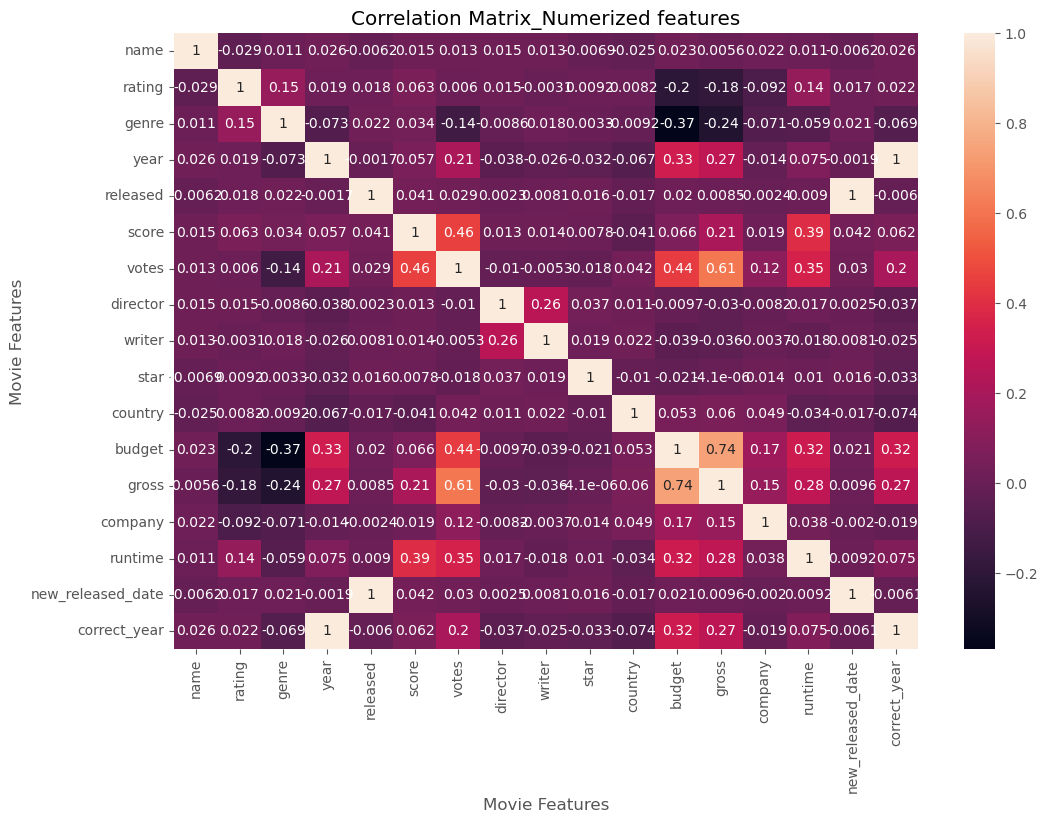

In [15]:
correlation_matrix2 = movies_raw_data_numerized.corr(method = "pearson")
#Using the correlation matrix to display a heatmap

sns.heatmap(correlation_matrix2, annot = True)
plt.title("Correlation Matrix_Numerized features")

plt.xlabel("Movie Features")
plt.ylabel("Movie Features")

plt.show()

# Conclusion

The correlation matrix shows that the company who released the movie is not highly correlated to the gross revenue.
A movie's gross revenue seems to be highly correlated to its budget. It is also highly correlated with "Votes" : the number of votes it accumulated on IMDb. Most popular movies had more votes on the websites

In [16]:
#Checking the conclusion
#Using unstack and sorting values to visualize correlation more easily
corr_pairs = correlation_matrix2.unstack()
sorted_corr_pairs = corr_pairs.sort_values()
#Separating highly correlated values in a separate dataframe
high_corr = sorted_corr_pairs[(sorted_corr_pairs) > 0.5]
high_corr

votes              gross                0.614751
gross              votes                0.614751
                   budget               0.740247
budget             gross                0.740247
year               correct_year         0.998726
correct_year       year                 0.998726
released           new_released_date    0.999951
new_released_date  released             0.999951
name               name                 1.000000
writer             writer               1.000000
runtime            runtime              1.000000
company            company              1.000000
gross              gross                1.000000
budget             budget               1.000000
country            country              1.000000
star               star                 1.000000
director           director             1.000000
votes              votes                1.000000
score              score                1.000000
released           released             1.000000
year               y